In [5]:
!git clone https://github.com/BollywoodData/Bollywood-Data

Cloning into 'Bollywood-Data'...
remote: Enumerating objects: 1853, done.
remote: Total 1853 (delta 0), reused 0 (delta 0), pack-reused 1853 (from 1)
Receiving objects: 100% (1853/1853), 37.71 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (21/21), done.


# Must Run Functions

In [1]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install gender_guesser
!pip install pymupdf

In [3]:
import os
import pymupdf
import re
import spacy
import pandas as pd
from gender_guesser.detector import Detector

nlp = spacy.load("en_core_web_sm")
gender_detector = Detector()

In [41]:
import re

def extract_intro_lines(text):
    lines = re.split(r'\n(?=[A-Z][a-z]+:|\s*[A-Z]+\s*$)', text)

    clean_lines = []
    for line in lines:
        line = line.strip()
        if not line.isupper() and not re.match(r'^[A-Z]+:$', line) and line:
             clean_lines.append(line)

    if len(clean_lines) < 10:
        print("Warning: Few lines extracted using script format. Falling back to sentence splitting.")
        doc = nlp(text)
        clean_lines = [sent.text.strip() for sent in doc.sents if sent.text.strip() and not sent.text.strip().isupper()]


    print(f"Extracted {len(clean_lines)} lines for analysis.")
    return clean_lines

In [49]:
def detect_character_and_gender(line):

    doc = nlp(line)
    for ent in doc.ents:

        if ent.label_ == "PERSON":
            name = ent.text

            gender = gender_detector.get_gender(name.split()[0])

            return name, gender

    return None, None

## Model Loading and Tokenizing

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.1"


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("✅ Model loaded on:", next(model.parameters()).device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded on: cuda:0


In [31]:
import pandas as pd
from tqdm import tqdm
import re
import time


def classify_stereotype_with_mistral_v5_silent(line):
   prompt = f"""
   You are a language model trained to detect gender stereotypes in lines from movie scripts.
   Your task is to classify each line into exactly one of the following 14 categories, based on the presence of stereotypical portrayals—especially of women.
   Assign only **one** label per line. Be careful to read subtle biases. Return only the **label** (not the line, not any explanation).
   Here are the 14 valid categories:
    1. occupation_gap → The character lacks a job, career mention, or professional identity.
      - Ex: "She stayed home while the others went to work."

    2. agency_gap → The character lacks independence or decision-making ability; is passive or submissive.
      - Ex: "She looked at him, waiting for his decision."

    3. appearance_focus → Emphasis on physical appearance, |beauty, clothing, or body—but not sexual objectification.
      - Ex: "She walked in wearing a tight red dress that hugged every curve."

    4. relationship_only → Introduced only as a relation to another (wife, daughter, etc.).
      - Ex: "That's John's wife, the one sitting by the window."

    5. screen_time_disparity→ Line shows that women have very limited screen/dialog presence.
      - Ex: "The male characters dominated every major scene, while she had only two lines."

    6. dialogue_initiation_gap → The woman doesn't start conversations or only speaks when spoken to.
      - Ex: "She rarely spoke unless someone asked her a question first."

    7. emotional_typecast → The woman is only shown as overly emotional, irrational, or tearful.
      - Ex: "She burst into tears again, as usual."

    8. domesticity_emphasis → Emphasis on domestic roles (cooking, cleaning, homemaking).
      - Ex: "She was happiest baking cookies in her cozy kitchen."

    9. objectification → The body is sexualized visually or narratively. Often includes gaze, zoom-ins, or body parts.
      - Ex: "The camera panned slowly from her legs to her chest."

    10. victim_only → The woman appears only to suffer harm or be rescued, with no further agency.
      - Ex: "She screamed for help as the villain grabbed her."

    11. intelligence_undermined → The woman is portrayed as dumb, ditzy, or confused—especially in academic/intellectual areas.
      - Ex: "She looked confused by the math problem and giggled nervously."

    12. support_role_only → Exists only to encourage, cheer for, or help a man without her own arc.
      - Ex: "She cheered him on from the sidelines as he accepted his award."

    13. villainization → Woman is unfairly portrayed as evil, manipulative, or cruel (e.g. stepmother, seductress).
      - Ex: "The evil stepmother glared with contempt and plotted her revenge."

    14. none → The line is empowering or neutral. No stereotype or bias.
      - Ex: "She led the mission with confidence and precision."

    ---

    Read the line carefully. Choose the **most accurate single category** from the above list.
    If the line contains no bias, use `none`.

    Line: "{line}"
    Label:"""
   inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
   outputs = model.generate(
       **inputs,
       max_new_tokens=10,
       pad_token_id=tokenizer.eos_token_id,
   )
   decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
   label_matches = re.findall(r"Label:\s*(\w+)", decoded)
   valid_labels = {
     "occupation_gap",
     "agency_gap",
     "appearance_focus",
     "relationship_only",
     "screen_time_disparity",
     "dialogue_initiation_gap",
     "emotional_typecast",
     "domesticity_emphasis",
     "objectification",
     "victim_only",
     "intelligence_undermined",
     "support_role_only",
     "villainization",
     "none"
   }
   label = next((lbl.lower() for lbl in reversed(label_matches) if lbl.lower() in valid_labels), "none")
   return label

In [32]:
test_sentences = {
    "occupation_gap": "She stayed home while the others went to work.",
    "agency_gap": "She looked at him, waiting for his decision.",
    "appearance_focus": "She walked in wearing a tight red dress that hugged every curve.",
    "relationship_only": "That's John's wife, the one sitting by the window.",
    "screen_time_disparity": "The male characters dominated every major scene, while she had only two lines.",
    "dialogue_initiation_gap": "She rarely spoke unless someone asked her a question first.",
    "emotional_typecast": "She burst into tears again, as usual.",
    "domesticity_emphasis": "She was happiest baking cookies in her cozy kitchen.",
    "objectification": "The camera panned slowly from her legs to her chest.",
    "victim_only": "She screamed for help as the villain grabbed her.",
    "intelligence_undermined": "She looked confused by the math problem and giggled nervously.",
    "support_role_only": "She cheered him on from the sidelines as he accepted his award.",
    "villainization": "The evil stepmother glared with contempt and plotted her revenge.",
    "none": "She led the mission with confidence and precision."
}

for expected, sentence in test_sentences.items():
    predicted = classify_stereotype_with_mistral_v5_silent(sentence)
    print(f"Expected: {expected} | Predicted: {predicted} | Line: {sentence}")

Expected: occupation_gap | Predicted: occupation_gap | Line: She stayed home while the others went to work.
Expected: agency_gap | Predicted: agency_gap | Line: She looked at him, waiting for his decision.
Expected: appearance_focus | Predicted: appearance_focus | Line: She walked in wearing a tight red dress that hugged every curve.
Expected: relationship_only | Predicted: relationship_only | Line: That's John's wife, the one sitting by the window.
Expected: screen_time_disparity | Predicted: screen_time_disparity | Line: The male characters dominated every major scene, while she had only two lines.
Expected: dialogue_initiation_gap | Predicted: dialogue_initiation_gap | Line: She rarely spoke unless someone asked her a question first.
Expected: emotional_typecast | Predicted: emotional_typecast | Line: She burst into tears again, as usual.
Expected: domesticity_emphasis | Predicted: domesticity_emphasis | Line: She was happiest baking cookies in her cozy kitchen.
Expected: objectific

# Working With Bollywood Bolly


In [4]:
def extract_script_text(pdf_path):
    with pymupdf.Document(pdf_path) as doc:
        return "\n".join([page.get_text() for page in doc])

def load_scripts_from_folder(folder_path):
    scripts = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            title = filename.replace('.pdf', '')
            text = extract_script_text(os.path.join(folder_path, filename))
            scripts[title] = text
    return scripts

scripts = load_scripts_from_folder("/content/Bollywood-Data/scripts-data")
print(f"✅ Loaded {len(scripts)} scripts.")

✅ Loaded 13 scripts.


In [30]:
clean_data = []

for title, text in scripts.items():
    lines = extract_intro_lines(text)
    for line in lines:
        character, gender = detect_character_and_gender(line)
        if character and gender in ['male', 'female']:
            clean_data.append({
                "script": title,
                "character": character,
                "gender": gender,
                "line": line.strip()
            })

df_cleaned = pd.DataFrame(clean_data)
df_cleaned.to_csv("cleaned_script_data_plots.csv", index=False)
print("✅ Saved cleaned data to cleaned_script_data_plots.csv")
df_cleaned.head()

✅ Saved cleaned data to cleaned_script_data_plots.csv


,script,character,gender,line
0,Maqbool,Nata,female,Nata…
1,Maqbool,Nata,female,What happened to Nata?
2,Maqbool,Nata,female,Sir… Nata… ?
3,Maqbool,Asif,male,That’s Abba ji’s brother-in-law’s turf. That A...
4,Maqbool,Jahangir Khan,male,Jahangir Khan… he was Lalji Bhai’s right hand....


In [11]:

df = pd.read_csv("cleaned_script_data_plots.csv")
chunk_size = 250

for start in range(0, len(df), chunk_size):
    end = min(start + chunk_size, len(df))
    chunk = df.iloc[start:end].copy()

    print(f"🧠 Processing lines {start} to {end}")
    tqdm.pandas()
    chunk["stereotype_type"] = chunk["line"].progress_apply(classify_stereotype_with_mistral_v5_silent)

    chunk.to_csv(f"chunk_{start}_{end}.csv", index=False)
    print(f"✅ Saved: chunk_{start}_{end}.csv")

    torch.cuda.empty_cache()
    time.sleep(2)

🧠 Processing lines 0 to 250


  4%|▍         | 10/250 [00:19<07:46,  1.94s/it]


KeyboardInterrupt: 

In [ ]:
import glob
import pandas as pd
files = sorted(glob.glob("chunk_*.csv"))
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all.to_csv("ai_stereotype_annotated_final.csv", index=False)
print("✅ All chunks merged and saved.")

## Ploting dataset results


✅ Saved: bias_scores_overall.csv
✅ Saved: bias_scores_by_gender.csv
✅ Saved: bias_trends_overall.png


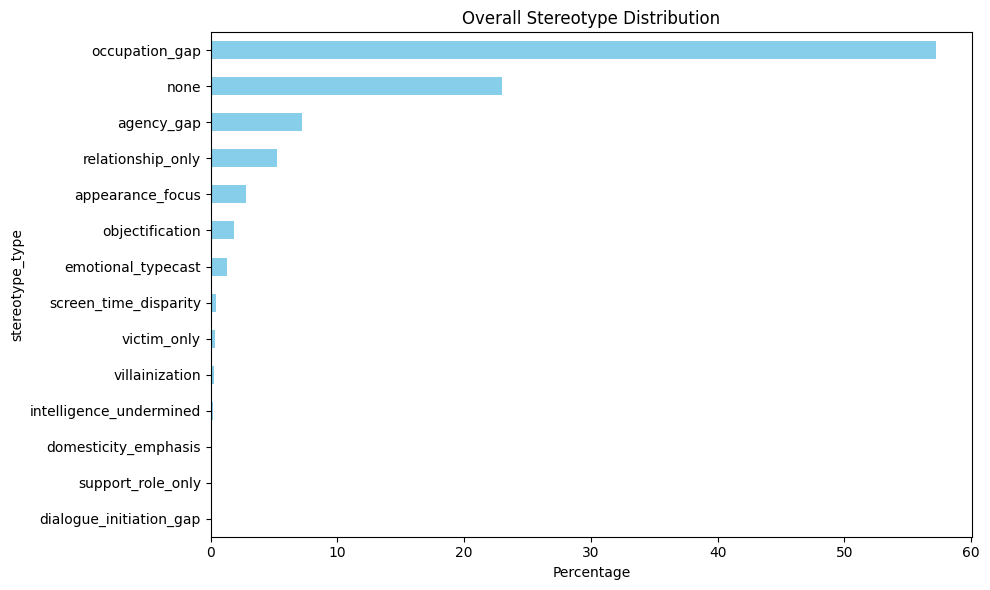

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r"ai_stereotype_annotated_final.csv")

assert 'gender' in df.columns and 'stereotype_type' in df.columns, "Missing required columns."

overall_bias_counts = df['stereotype_type'].value_counts()
overall_bias_percentages = (overall_bias_counts / overall_bias_counts.sum()) * 100
overall_bias_percentages.to_csv(r"bias_scores_overall.csv", index_label="stereotype_type", header=["percentage"])
print("✅ Saved: bias_scores_overall.csv")

bias_by_gender = df.groupby(['gender', 'stereotype_type']).size().unstack(fill_value=0)
bias_by_gender_percent = bias_by_gender.div(bias_by_gender.sum(axis=1), axis=0) * 100
bias_by_gender_percent.to_csv(r"bias_scores_by_gender.csv", index_label="gender")
print("✅ Saved: bias_scores_by_gender.csv")

plt.figure(figsize=(10, 6))
overall_bias_percentages.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.xlabel("Percentage")
plt.title("Overall Stereotype Distribution")
plt.tight_layout()
plt.savefig(r"bias_trends_overall.png")
print("✅ Saved: bias_trends_overall.png")
plt.show()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("✅ Mistral model loaded.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Mistral model loaded.


In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("ai_stereotype_annotated_final.csv")

def rewrite_biased_line_with_mistral_v2(line, stereotype_type):
    prompt = f"""
You are a helpful assistant trained to rewrite movie script lines that reinforce gender stereotypes.

Stereotype detected: {stereotype_type}

Avoid rephrasing the same stereotype. Instead, remove the biased framing and rewrite the line by giving the character agency, ambition, or equality, while preserving narrative meaning.

Line: "{line}"
Rewritten line:"""

    inputs = tokenizer(prompt.strip(), return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    rewritten_line = decoded.split("Rewritten line:")[-1].strip().strip('"')
    return rewritten_line
tqdm.pandas()

df["rewritten_line"] = df.progress_apply(
    lambda row: rewrite_biased_line_with_mistral_v2(row["line"], row["stereotype_type"])
    if row["stereotype_type"] != "none" else row["line"],
    axis=1
)

df.to_csv("phase4a_rewrites.csv", index=False)
print("✅ Saved Phase 4A output to phase4a_rewrites.csv")


  0%|          | 5/2296 [1:09:41<571:42:00, 898.35s/it]

In [ ]:
!pip install reportlab

## PDF Making


In [ ]:

import pandas as pd
from tqdm import tqdm
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet

df = pd.read_csv(r"D:\PROG\docu3C\BollyAI_2_0\output\phase4a_rewrites (1).csv")  # Output of Phase 4A
df = df[df['stereotype_type'] != 'none'].copy()

severity_map = {
    "appearance_focus": 2,
    "relationship_only": 2,
    "agency_gap": 3,
    "occupation_gap": 3,
}
df["severity_score"] = df["stereotype_type"].map(severity_map).fillna(1)

df["rewrite"] = df["rewritten_line"]

df["rank"] = df["severity_score"].rank(method="dense", ascending=False).astype(int)

df.to_csv(r"feedback_report.csv", index=False)
print("✅ CSV report saved as feedback_report.csv")

doc = SimpleDocTemplate(r"feedback_report.pdf", pagesize=A4)
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("🎬 Bollywood Bias Buster – Script Feedback Report", styles["Title"]))
elements.append(Spacer(1, 12))

data = [["#", "Original Line", "Stereotype", "Severity", "Rewritten Line"]]

for idx, row in df.sort_values("rank").iterrows():
    data.append([
        row["rank"],
        row["line"],
        row["stereotype_type"],
        int(row["severity_score"]),
        row["rewrite"]
    ])

table = Table(data, colWidths=[30, 160, 85, 60, 180])
table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
    ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
    ("ALIGN", (0, 0), (-1, -1), "LEFT"),
    ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
    ("FONTSIZE", (0, 0), (-1, -1), 7),
    ("BOTTOMPADDING", (0, 0), (-1, 0), 6),
    ("GRID", (0, 0), (-1, -1), 0.25, colors.black),
]))

for i in range(1, len(data)):
    if int(data[i][3]) >= 3:
        table.setStyle([("BACKGROUND", (0, i), (-1, i), colors.lightpink)])

elements.append(table)
doc.build(elements)

print("✅ PDF report saved as feedback_report.pdf")


# User Input

In [21]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.0 MB/s eta 0:00:00


In [47]:

from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.enums import TA_LEFT, TA_CENTER
import pandas as pd
from tqdm import tqdm
import re
import spacy
from gender_guesser.detector import Detector
import os
import pymupdf

try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Loading en_core_web_sm model for spaCy...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

try:
    gender_detector = Detector()
except:
    print("Initializing gender_guesser Detector...")
    gender_detector = Detector()



def generate_pdf_report_from_dataframe(df_data, output_path, bias_score=None, stereotype_distribution=None):
    """
    Generates a PDF report from a pandas DataFrame containing analysis results,
    including overall bias score and stereotype distribution.

    Args:
        df_data (pd.DataFrame): DataFrame with analysis results (line, stereotype, severity, rewrite, rank).
        output_path (str): The path to save the PDF report.
        bias_score (float, optional): The calculated overall bias score. Defaults to None.
        stereotype_distribution (pd.Series, optional): Value counts of stereotype types. Defaults to None.
    """
    doc = SimpleDocTemplate(output_path, pagesize=A4)
    styles = getSampleStyleSheet()
    elements = []

    elements.append(Paragraph("🎬 Bollywood Bias Buster – Script Feedback Report", styles["Title"]))
    elements.append(Spacer(1, 18))

    intro_text = """
    This report provides an analysis of potential gender stereotypes detected in the provided movie script lines.
    The analysis identifies specific lines that may reinforce common stereotypes and suggests rewritten alternatives.
    A bias score is calculated based on the severity of detected stereotypes.
    """
    elements.append(Paragraph(intro_text, styles["Normal"]))
    elements.append(Spacer(1, 12))

    if bias_score is not None:
        elements.append(Paragraph(f"<b>Overall Script Bias Score:</b> <font color='red'>{bias_score:.2f}</font>", styles["h2"])) # Use h2 style for prominence
        elements.append(Spacer(1, 12))

    if stereotype_distribution is not None and not stereotype_distribution.empty:
        elements.append(Paragraph("<b>Stereotype Distribution:</b>", styles["h3"])) # Use h3 style
        elements.append(Spacer(1, 6))

        distribution_data = [["Stereotype Type", "Count", "Percentage"]]
        total_stereotypes = stereotype_distribution.sum()
        for stereotype, count in stereotype_distribution.items():
            percentage = (count / total_stereotypes) * 100 if total_stereotypes > 0 else 0
            distribution_data.append([stereotype.replace('_', ' ').title(), count, f"{percentage:.1f}%"]) # Improve label formatting

        distribution_table = Table(distribution_data, colWidths=[200, 50, 70]) # Added column for percentage
        distribution_table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, -1), "LEFT"),
             ("ALIGN", (-2, 0), (-1, -1), "CENTER"), # Center align count and percentage
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("FONTSIZE", (0, 0), (-1, -1), 8),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 6),
            ("GRID", (0, 0), (-1, -1), 0.25, colors.black),
        ]))
        elements.append(distribution_table)
        elements.append(Spacer(1, 18)) # Increased space


    if df_data.empty:
        elements.append(Paragraph("No gender stereotypes or characters with detected gender found in the script lines for detailed reporting.", styles["Normal"]))
        print("ℹ️ No biased lines or relevant characters found for detailed report.")
    else:
        elements.append(Paragraph("<b>Detected Stereotypes Details:</b>", styles["h3"])) # Use h3 style
        elements.append(Spacer(1, 6))

        for idx, row in df_data.sort_values(["rank", "severity_score"], ascending=[True, False]).iterrows():
            # Add original line
            elements.append(Paragraph(f"<b>Original Line ({row['rank']}):</b> {row['line']}", styles["Normal"]))
            elements.append(Spacer(1, 3))

            # Add stereotype and severity
            elements.append(Paragraph(f"<b>Stereotype:</b> {row['stereotype_type'].replace('_', ' ').title()} (Severity: {int(row['severity_score'])})", styles["Normal"]))
            elements.append(Spacer(1, 3))

            # Add rewritten line
            elements.append(Paragraph(f"<b>Rewritten Line:</b> {row['rewritten_line']}", styles["Normal"]))
            elements.append(Spacer(1, 12)) # Add space between entries


    try:
        doc.build(elements)
        print(f"✅ PDF report saved as {output_path}")
        return output_path
    except Exception as e:
        print(f"Error building PDF: {e}")
        return None


def analyze_script_and_generate_report(script_text, script_title="Single Script Analysis"):
    """
    Analyzes a single script for stereotypes, calculates bias score and distribution,
    and generates a PDF report.

    Args:
        script_text (str): The content of the movie script.
        script_title (str): The title of the script (for reporting).

    Returns:
        str: The path to the generated PDF report file, or None if report generation failed.
    """
    print(f"Analyzing script: {script_title}")
    lines = extract_intro_lines(script_text)
    print(f"Extracted {len(lines)} potential lines for analysis.")
    analysis_results = []

    if 'model' not in globals() or 'tokenizer' not in globals() or model is None or tokenizer is None:
         print("Error: Mistral model or tokenizer not loaded. Cannot perform stereotype classification.")
         # Generate a report indicating model not loaded
         output_pdf_path = f"{script_title.replace(' ', '_').replace('/', '_')}_feedback_report.pdf"
         generated_pdf_path = generate_pdf_report_from_dataframe(pd.DataFrame(), output_pdf_path, bias_score=0, stereotype_distribution=pd.Series())
         return generated_pdf_path


    print("Starting stereotype classification...")
    for line in tqdm(lines, desc="Classifying stereotypes"):
        character, gender = detect_character_and_gender(line)
        if character and gender in ['male', 'female']:
             stereotype_type = classify_stereotype_with_mistral_v5_silent(line)
             # print(f"  -> Stereotype: {stereotype_type}") # Debug print
             analysis_results.append({
                 "script": script_title,
                 "character": character,
                 "gender": gender,
                 "line": line.strip(),
                 "stereotype_type": stereotype_type
             })

    print(f"Finished classification. Found {len(analysis_results)} lines with detected characters.")
    df_analysis = pd.DataFrame(analysis_results)
    print(f"DataFrame shape after character detection: {df_analysis.shape}")

    # Calculate Stereotype Distribution (before filtering 'none')
    stereotype_distribution = df_analysis['stereotype_type'].value_counts() if not df_analysis.empty and 'stereotype_type' in df_analysis.columns else pd.Series()
    print("Stereotype distribution calculated.")
    print(stereotype_distribution)


    # Filter out 'none' stereotypes for the detailed report table
    df_report_data = df_analysis[df_analysis['stereotype_type'] != 'none'].copy() if not df_analysis.empty and 'stereotype_type' in df_analysis.columns else pd.DataFrame()
    print(f"DataFrame shape after filtering 'none' stereotypes: {df_report_data.shape}")


    # Calculate Overall Bias Score
    # Use severity map on the full analysis DataFrame to include 'none' with severity 1 (or 0 if preferred)
    severity_map = {
        "appearance_focus": 2, "relationship_only": 2, "agency_gap": 3,
        "occupation_gap": 3, "emotional_typecast": 2, "domesticity_emphasis": 2,
        "objectification": 3, "victim_only": 3, "intelligence_undermined": 2,
        "support_role_only": 2, "villainization": 3, "none": 1 # Assign a base score for 'none'
    }
    # Apply severity map to the full df_analysis to get a score for every analyzed line
    if not df_analysis.empty and 'stereotype_type' in df_analysis.columns:
        df_analysis["severity_score"] = df_analysis["stereotype_type"].map(severity_map).fillna(1) # Fillna for any unexpected labels
        # Calculate average severity score as a simple bias score
        overall_bias_score = df_analysis["severity_score"].mean()
    else:
        overall_bias_score = 0 # Default to 0 if no lines were analyzed

    print(f"Overall bias score calculated: {overall_bias_score:.2f}")


    # Add severity score and rank to the filtered report data
    if not df_report_data.empty:
        df_report_data["severity_score"] = df_report_data["stereotype_type"].map(severity_map).fillna(1)
        print("Severity scores added to report data.")

        tqdm.pandas(desc="Rewriting biased lines")
        df_report_data["rewritten_line"] = df_report_data.progress_apply(
            lambda row: rewrite_biased_line_with_mistral_v2(row["line"], row["stereotype_type"]),
            axis=1
        )
        print("Rewritten lines added to report data.")

        df_report_data["rank"] = df_report_data["severity_score"].rank(method="dense", ascending=False).astype(int)
        print("Rank added to report data.")
    else:
        print("No biased lines in report data to add severity, rewrite, or rank.")
        # Ensure columns exist even if empty for consistent PDF generation
        df_report_data = pd.DataFrame(columns=["script", "character", "gender", "line", "stereotype_type", "severity_score", "rewritten_line", "rank"])


    # Generate the PDF report
    output_pdf_path = f"{script_title.replace(' ', '_').replace('/', '_')}_feedback_report.pdf"
    print(f"Generating PDF report: {output_pdf_path}")
    generated_pdf_path = generate_pdf_report_from_dataframe(df_report_data, output_pdf_path, overall_bias_score, stereotype_distribution)


    return generated_pdf_path

In [35]:
import pandas as pd
from tqdm import tqdm

def rewrite_biased_line_with_mistral_v2(line, stereotype_type):
    prompt = f"""
You are a helpful assistant trained to rewrite movie script lines that reinforce gender stereotypes.

Stereotype detected: {stereotype_type}

Avoid rephrasing the same stereotype. Instead, remove the biased framing and rewrite the line by giving the character agency, ambition, or equality, while preserving narrative meaning.

Line: "{line}"
Rewritten line:"""

    # Ensure model and tokenizer are accessible globally
    if 'model' not in globals() or 'tokenizer' not in globals() or model is None or tokenizer is None:
         print("Error: Mistral model or tokenizer not loaded. Cannot perform line rewriting.")
         return line # Return original line if model is not loaded


    inputs = tokenizer(prompt.strip(), return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Extract only the rewritten line
    rewritten_line = decoded.split("Rewritten line:")[-1].strip().strip('"')
    return rewritten_line



In [ ]:
import gradio as gr
import os # Import os for file path handling

# Assuming analyze_script_and_generate_report function is defined in a previous cell and works correctly

def interface_analyze_script(script_text, script_title="User_Script"):
    """
    Wrapper function for the Gradio interface to analyze a script and generate a PDF.
    """
    if not script_text:
        return None # Return None if no script text is provided

    # Clean the script title for use in filenames
    cleaned_script_title = script_title.replace(' ', '_').replace('/', '_')
    if not cleaned_script_title: # Handle cases where cleaning results in an empty string
        cleaned_script_title = "User_Script"

    # Generate the PDF report using the existing function
    pdf_report_path = analyze_script_and_generate_report(script_text, cleaned_script_title)

    if pdf_report_path and os.path.exists(pdf_report_path):
        return pdf_report_path
    else:
        print(f"Error: PDF report not found at {pdf_report_path}")
        return None

# Create the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown(
        """
        # 🎬 Bollywood Bias Buster - Script Analysis Interface
        Paste your movie script below and get a PDF report analyzing potential gender stereotypes.
        """
    )
    script_input = gr.Textbox(label="Paste Movie Script Here", lines=20, placeholder="Enter script text...")
    script_title_input = gr.Textbox(label="Script Title (Optional)", placeholder="Enter title...")
    output_pdf = gr.File(label="Bias Report PDF")
    analyze_button = gr.Button("Analyze Script and Generate Report")

    analyze_button.click(
        interface_analyze_script,
        inputs=[script_input, script_title_input],
        outputs=output_pdf
    )

# Launch the interface
if __name__ == "__main__":
    demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0909f7c28a4dfe050e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Analyzing script: Animal
Extracted 35 lines for analysis.
Extracted 35 potential lines for analysis.
Starting stereotype classification...


Classifying stereotypes: 100%|██████████| 35/35 [00:41<00:00,  1.18s/it]


Finished classification. Found 18 lines with detected characters.
DataFrame shape after character detection: (18, 5)
Stereotype distribution calculated.
stereotype_type
occupation_gap    13
agency_gap         3
villainization     1
none               1
Name: count, dtype: int64
DataFrame shape after filtering 'none' stereotypes: (17, 5)
Overall bias score calculated: 2.89
Severity scores added to report data.


Rewriting biased lines: 100%|██████████| 17/17 [04:04<00:00, 14.36s/it]


Rewritten lines added to report data.
Rank added to report data.
Generating PDF report: Animal_feedback_report.pdf
✅ PDF report saved as Animal_feedback_report.pdf
